In [14]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install keras-core

Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install qiskit-aer

  Obtaining dependency information for qiskit-aer from https://files.pythonhosted.org/packages/10/3a/09935130dbb72ec4154a067f5611c83ae25eb1af1ff9ffb5e445b33afb33/qiskit_aer-0.12.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB 1.9 MB/s eta 0:00:05
    --------------------------------------- 0.2/9.6 MB 2.3 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/9.6 MB 4.9 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/9.6 MB 6.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/9.6 MB 9.8 MB/s eta 0:00:01
   ------------- -------------------------- 3.3/9.6 MB 12.5 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.6 MB 13.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.6 MB 13.2 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 15.0 MB/s eta 0:00:01
   -------------------------

In [ ]:
#importamos los modulos necesarios
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score
from qiskit.circuit.library.standard_gates import RYGate, RYYGate
import cv2
import pandas as pd

# Circuito cuantico para FRQI 
#### En la implementacion de FRQI, el metodo lo podemos dividir en 3 partes
#### 1. La super posicion de los pixeles en los qubits  
#### 2. El uso de X-Gates para cambiar la posicion de los pixeles en los qubits
#### 3. La aplicacion de $C^{n}(R_{y}(θ))$

In [12]:
# En este codigo aplicacmos la compuerta hadamard al pixel "n"
def hadamard(circ, n):
  for i in n:
    circ.h(i)

# Cambio de pixeles

In [13]:

# This function let us know which are the qubits that need to be applied  
# the X-gate so we can change the state of the pixels positions qubits
# to the new state.
def change(state, new_state):
  n = len(state)  # n is the length of the binary string
  c = np.array([])  # create an empty array
  for i in range(n):  # start to iterate n times
    if state[i] != new_state[i]:  # here we check if the position i in the 
                                  # binary string is different
      c = np.append(c, int(i))

  if len(c) > 0:
    return c.astype(int)
  else:
    return c

In [18]:
# This function applies the X-gates to the corresponding qubits given by 
# the change function
def binary(circ, state, new_state):
  # state is the string in binary format that tells us the actual state of the pixels
  # state = '000000'
  c = change(state, new_state)
  if len(c) > 0:
    # Modified section. Added the -1 and the np.abs
    circ.x(np.abs(c-5))
  else: 
    pass

### Aplicacion  de la compuerta $C^{n}(R_{y}(θ_i))$ 
Mientras estamos iterando en la posición del píxel tenemos que aplicar el $C^{n}(R_{y}(θ))$. Una vez que cambiamos el estado de los qubits a la posición de píxel correspondiente, aplicamos el $C^{n}(R_{y}(θ_i))$ respectivo, donde $\theta_{i}$ denota el valor de escala de grises (0 a 255) del píxel $i$ respectivo.

In [19]:
# This function applies the C^n(Ry) (controlled Ry gate) in the quantum circuit
# "circ" using the vector "n" for the controlled qubits and the variable "t" for
# the target qubit, and "theta" for the angle in the rotation. 
def cnri(circ, n, t, theta):
  #rq = circuit.qubits
  controls = len(n)
  cry = RYGate(2*theta).control(controls)
  aux = np.append(n, t).tolist()
  circ.append(cry, aux)

In [38]:
# The frqi function calls all of the aleady defined function to fully implement
# The FRQI method over the quantum circuit "circ", with the vector of controlled
# qubits "n", the target qubit "t" and the angles of each pixel in the image.
def frqi(circ,n ,t, angles):
  hadamard(circ, n)
  j = 0
  for i in angles:
    state = '{0:06b}'.format(j-1)
    new_state = '{0:06b}'.format(j)
    if j == 0:
      cnri(circ, n, t, i)
    else:
      binary(circ, state, new_state)
      cnri(circ, n, t, i)
    j += 1
    

## Conjunto de datos de MNIST

En esta sección sólo vamos a descargar el conjunto de datos MNIST para poder utilizar una de las imágenes para la codificación y la recuperación.

In [21]:
# Read the csv file
dataset = pd.read_csv('mnist-resized.csv')

In [22]:
# Reshape and transform the dataframe into a numpy array
images = dataset.to_numpy()[:,1:].reshape(42000,8,8)

In [23]:
# Reshape the array
pixel_values = images.reshape(42000,64)

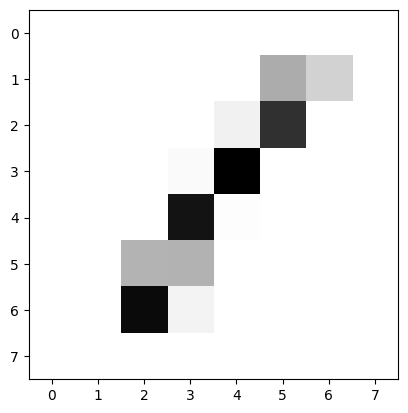

In [29]:
# Plot an image to see if the changes made are right 
plt.imshow(images[0,:], cmap='Greys')

In [65]:
# Plot an image to see if the changes made are right 
# Transform the normalized values into angles before we introduce them into 
# the Ry rotations
## Clip the values to the range [-1, 1]
angles = np.arcsin(np.clip(images[0,:], -1, 1))
# Print the angles
print(angles)

[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         1.57079633
  1.57079633 0.        ]
 [0.         0.         0.         0.         1.57079633 1.57079633
  0.         0.        ]
 [0.         0.         0.         1.57079633 1.57079633 0.
  0.         0.        ]
 [0.         0.         0.         1.57079633 1.57079633 0.
  0.         0.        ]
 [0.         0.         1.57079633 1.57079633 0.         0.
  0.         0.        ]
 [0.         0.         1.57079633 1.57079633 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


###  Quantum encoding and retrieval of image 

In [44]:
# Declare the Quantum and Classical registers
qr = QuantumRegister(7,'q')
cr = ClassicalRegister(7,'c')

In [45]:
# Build a quantum circuit
qc = QuantumCircuit(qr,cr)

In [48]:
# Call the frqi function and add all the necessary parameters
matrix = [0,1,2,3,4,5]
frqi(qc, matrix, 6, angles)

CircuitError: "Invalid param type <class 'numpy.ndarray'> for gate ry."

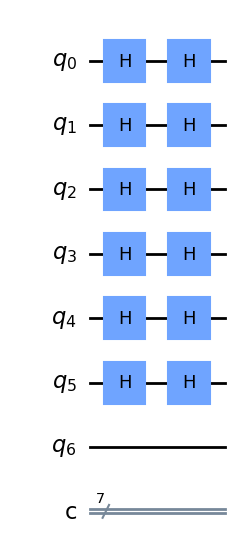

In [49]:
# (Optional) We Can see how the quantum circuit is structured using qc.draw()
qc.draw(output = 'mpl')

In [50]:
# Measure all the qubits in the quantum circuit
qc.measure([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])

In [53]:
# Create our backend to run the quantum simulation
backend_sim = Aer.get_backend('qasm_simulator')
numOfShots = 1048576
result = execute(qc, backend_sim, shots=numOfShots).result()

In [54]:
# (Optional) Print the results of the measurements
print(result.get_counts(qc)) 

{'0000000': 1048576}


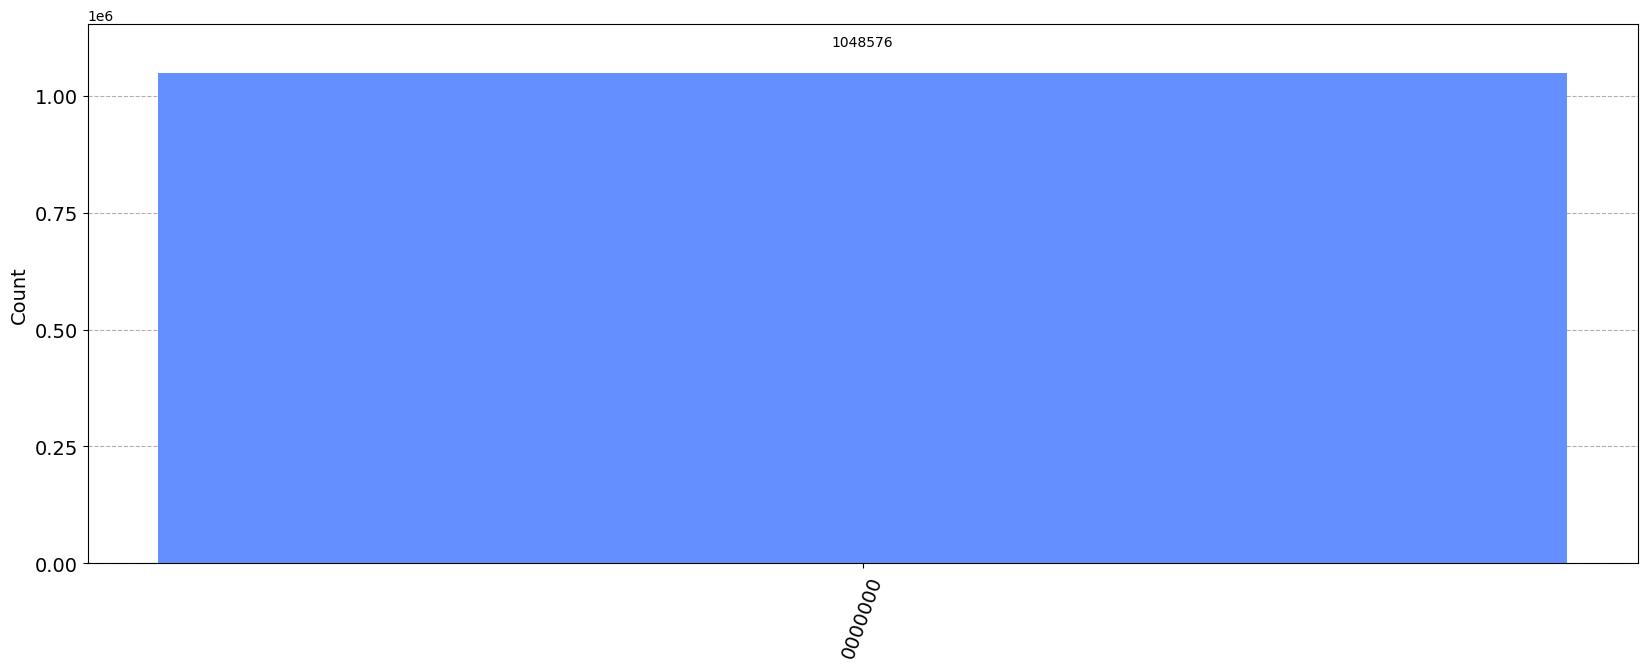

In [55]:
# (Optional) Print the results of the measurements as histogram
plot_histogram(result.get_counts(qc), figsize=(20,7))

In [56]:
# Create an empty array to save the retrieved image
retrieve_image = np.array([])

In [57]:
# We iterate over all the pixels and obtain the proability results for each one of them
# Notice that we compute the ratio of the white states, and only if the values are 0
# we make an exception and turn that pixel 0
for i in range(64):
  try:
    s = format(i, '06b')
    new_s = '1' + s
    retrieve_image = np.append(retrieve_image,np.sqrt(result.get_counts(qc)[new_s]/numOfShots))
  except KeyError:
    retrieve_image = np.append(retrieve_image,[0.0])

In [58]:
# We make the inverse nomalization
retrieve_image *=  8.0*255.0

In [59]:
# Turn the array into a type int
retrieve_image = retrieve_image.astype('int')

In [60]:
# Reshape the array into a 8x8 matrix
retrieve_image = retrieve_image.reshape((8,8))

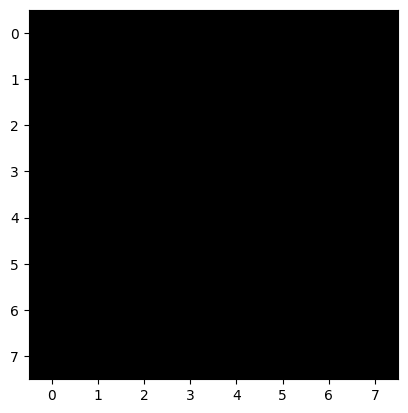

In [61]:
# Plot the retrieved image to see if it is the same as the one encoded
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.show()